# Neural Network
Classifing student success data by means of the [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) from the sklearn module.


## Import Data/ Data Transformation
For fitting a multi-layer perception model for classification it is suggested that you standardize the design matrix otherwise optimization of the weights are less likely to converge in fewer iterations. Hence after importing the data and converting the response class labels, we scale the design matrix.

In [1]:
import time
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import cartesian
from sklearn import metrics
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib


df = pd.read_csv('student-por2.csv')
df = pd.get_dummies(df)#, drop_first=True)

def response_conv(arr):
    new = []
    for i in arr:
        if (i > 0 and i < 10):           # condition where student failed
            new.append(0)                 
                                          
        elif (i >= 10):                   # condition where student passed
            new.append(1)                 
    
        else:                             # condition where student received an incomplete
            new.append(2)
    return(new)                           # 1-dimensional response varibale returned

X = df.drop('G3',1)                       # This is the design matrix
y = list(df.G3)                           # This is the discrete response vector
y_new = response_conv(y)                  # This is the multinomial response vector
X_scale = preprocessing.scale(X)

## Optimal Parameters for NN
Here we use 10-fold cross validation to make sure that we return the model with the best accuracy. We also print out the values for each parameter that make the model optimal. Lastly return the run time of the cross validation process

In [2]:
random.seed(42)

X1_train, X1_test, y1_train, y1_test = train_test_split(X_scale, y_new, test_size=0.33, random_state=42)

start_time = time.time()
combos = cartesian([['constant'],['sgd'],['logistic', 'tanh', 'relu'],10.0**-np.arange(1,7)])
in_layer_size = len(list(X))
out_layer_size = 3
hidden_layer_size = int((in_layer_size+out_layer_size)/2)

def opt(X,y):
    acc = []
    for learn,solver,act,alpha in combos:
        nn = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,),activation=act,solver=solver,learning_rate=learn,alpha=float(alpha),learning_rate_init = 0.2,random_state=42)
        scores = cross_val_score(nn, X, y, cv=10, scoring='accuracy')
        acc.append(scores.mean())
    

    opt_ = combos[acc.index(max(acc))]
    return(opt_)

lea1,sol1,act1,alp1 = opt(X1_train,y1_train)

print("Optimal parameters for standardized design matrix are as follows: \nHidden layer size: %r \nActivation function: %s \nSolver for weight optimization: %s \nLearning rate: %s \nAlpha(penalty parameter): %r" % (hidden_layer_size,act1,sol1,lea1,float(alp1)))
print("Cross Validation took %r minutes." % (int(time.time() - start_time)/60))


Optimal parameters for standardized design matrix are as follows: 
Hidden layer size: 30 
Activation function: relu 
Solver for weight optimization: sgd 
Learning rate: constant 
Alpha(penalty parameter): 0.1
Cross Validation took 0.3 minutes.


## Fit and Plot the Cost Function for Stochastic Gradient Descent
Here we fit the model with the optimal parameters found in the last section. We return a plot of the Cost Function converging to its minimum after a specific number of iterations. As expected we see convergance and have a good model for prediction.

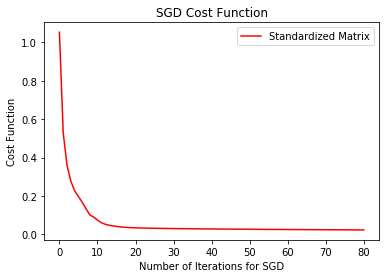

In [3]:
mlp1 = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,),activation=act1,solver=sol1,learning_rate=lea1,learning_rate_init = 0.2,alpha=float(alp1),random_state=42)
nn1 = mlp1.fit(X1_train,y1_train)


plt.figure()
plt.title("SGD Cost Function")
plt.xlabel("Number of Iterations for SGD")
plt.ylabel("Cost Function")
plt.plot(nn1.loss_curve_, 'r-', label='Standardized Matrix')
plt.legend()

## Neural Net Layers and Weighted Coefficients
This step is to get an idea of the weighted coefficients used for each neuron in the *hidden* and *outside* layers. The hidden layer is denoted by *0* and the outside layer is denoted by *1*. **Note** In this example we only have one hidden layer and one outside layer. In previous steps we found the best number of neurons on the hidden layer was 30, thus in the hidden layer the first neuron is denoted by *0* and the last neuron is denoted by *29*. For each neuron in every layer the *SGD* optimal weights array is returned.

In [4]:
print("Layer, Neuron, and Weights for standardized design matrix.")
for i in range(len(mlp1.coefs_)):
    n_neurons_per_layer = mlp1.coefs_[i].shape[1]
    for j in range(n_neurons_per_layer):
        w = mlp1.coefs_[i][:,j]
        print("Layer: %r \nNeuron: %r \nWeights: %r" %(i, j, w) , end=", ")
        print()
    print()


Layer, Neuron, and Weights for standardized design matrix.
Layer: 0 
Neuron: 0 
Weights: array([ 0.06263697,  0.05439814, -0.08611071, -0.46551536,  0.00519754,
        0.17871103,  0.04394986, -0.16128204, -0.002872  ,  0.30853032,
        0.19546622, -0.1225424 , -0.01181599,  0.4176992 ,  0.55058984,
        0.19304923, -0.07992313, -0.04546058,  0.20336475,  0.12319385,
       -0.21142383, -0.07111921,  0.09044346, -0.04996244,  0.12287251,
       -0.16602844,  0.20532183,  0.40171683, -0.52355455,  0.00257011,
        0.05142041, -0.11362136,  0.08033124, -0.1779292 ,  0.00948104,
       -0.09483933,  0.23532698,  0.09106091,  0.16840675, -0.16157959,
        0.10606762,  0.38399262, -0.02008588, -0.07287674, -0.15368455,
        0.18544389, -0.01277256, -0.16270904,  0.07319994,  0.0762067 ,
       -0.02320797, -0.02398815,  0.15988566, -0.14712526,  0.10064224,
       -0.23939304,  0.10254465, -0.24219741]), 
Layer: 0 
Neuron: 1 
Weights: array([ 0.16671758, -0.07002302, -0.1316

## Predict
This step is to make predictions on the test set we set aside that the model has yet to see and was not trianed on. Returns a data frame of the actaul *y* values and the perdicted *y* values. This data frame helps us to visually see where our model made incorrect predictions.

In [5]:
nn_pred1 = nn1.predict(X1_test)

pred = pd.DataFrame(list(zip(y1_test, nn_pred1)), columns=['y_act','y_nn_stan'])
pred.index.name = 'Obs'
pred

,y_act,y_nn_stan
Obs,,
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,0,0
8,1,1


## Results
Accuracy, confusion matrix, and classification reports are returned for the standardized design matirx.

In [6]:
cm_nn1 = pd.DataFrame(metrics.confusion_matrix(y1_test, nn_pred1), index = ['Fail(0)','Pass(1)','Inc(2)'],columns=['Fail(0)','Pass(1)','Inc(2)'])

print ("The accuracy of the Standardized Neural Network model is: ", nn1.score(X1_test,y1_test))
print ("\n")

print("Standardized Neural Network Confusion Matrix: \n", cm_nn1)
print ("\n")

print("Classification report for standardized design matrix:\n", metrics.classification_report(y1_test,nn_pred1))

The accuracy of the Standardized Neural Network model is:  0.906976744186


Standardized Neural Network Confusion Matrix: 
          Fail(0)  Pass(1)  Inc(2)
Fail(0)       14        9       0
Pass(1)        7      180       0
Inc(2)         2        2       1


Classification report for standardized design matrix:
              precision    recall  f1-score   support

          0       0.61      0.61      0.61        23
          1       0.94      0.96      0.95       187
          2       1.00      0.20      0.33         5

avg / total       0.91      0.91      0.90       215

